In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from sklearn.manifold import TSNE

In [39]:
latent_dim = 2
num_epochs = 16

In [40]:
def max_pow2_smaller_x(x):
    return 1 << (x.bit_length() - 1)

print(max_pow2_smaller_x(784))

512


In [43]:

# VAE Model
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder
        # self.encoder = nn.Sequential(
        #     nn.Linear(28 * 28, 768),
        #     nn.LeakyReLU(),
        #     nn.Linear(768, 512),
        #     nn.LeakyReLU(),
        #     nn.Linear(512, 256),
        #     nn.LeakyReLU(),
        #     nn.Linear(256, 128),
        #     nn.LeakyReLU(),
        # )
        self.max_layer_count = 20
        self.input_width = 28 * 28

        hidden_width = max_pow2_smaller_x(self.input_width)

        self.encoder = nn.Sequential()
        self.encoder.add_module("lin_in", nn.Linear(self.input_width, hidden_width))
        self.encoder.add_module(f"relu_in", nn.LeakyReLU())

        for i in range(self.max_layer_count):
            print(i, hidden_width)
            if (hidden_width >> 1) <= latent_dim:
                break
            self.encoder.add_module(f"lin_h{i}", nn.Linear(hidden_width, hidden_width >> 1))
            self.encoder.add_module(f"relu_h{i}", nn.LeakyReLU())
            hidden_width = hidden_width >> 1

        print(self.encoder)
        
        self.fc_mu = nn.Linear(hidden_width, latent_dim)  # Mean of latent space
        self.fc_log_var = nn.Linear(hidden_width, latent_dim)  # Log-variance of latent space

        print(self.fc_mu)
        print(self.fc_log_var)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 768),
            nn.LeakyReLU(),
            nn.Linear(768, 784),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)  # Sample epsilon from standard normal
        return mu + eps * std

    def forward(self, x):
        # Encode
        x = self.encoder(x)
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)

        # Reparameterize
        z = self.reparameterize(mu, log_var)

        # Decode
        x_reconstructed = self.decoder(z)
        return x_reconstructed, mu, log_var


# Loss function (Reconstruction + KL Divergence)
def vae_loss(reconstructed, original, mu, log_var):
    # Reconstruction loss
    recon_loss = nn.MSELoss(reduction='sum')(reconstructed, original)

    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    return recon_loss + kl_loss

In [44]:
# Define a transformation pipeline
transform = transforms.Compose([
    transforms.ToTensor(),               # Convert input to tensor in [0, 1]
])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = data.DataLoader(train_dataset, batch_size=256, shuffle=True)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model, optimizer, and training setup
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0007)

Using device: cuda
0 512
1 256
2 128
3 64
4 32
5 16
6 8
7 4
Sequential(
  (lin_in): Linear(in_features=784, out_features=512, bias=True)
  (relu_in): LeakyReLU(negative_slope=0.01)
  (lin_h0): Linear(in_features=512, out_features=256, bias=True)
  (relu_h0): LeakyReLU(negative_slope=0.01)
  (lin_h1): Linear(in_features=256, out_features=128, bias=True)
  (relu_h1): LeakyReLU(negative_slope=0.01)
  (lin_h2): Linear(in_features=128, out_features=64, bias=True)
  (relu_h2): LeakyReLU(negative_slope=0.01)
  (lin_h3): Linear(in_features=64, out_features=32, bias=True)
  (relu_h3): LeakyReLU(negative_slope=0.01)
  (lin_h4): Linear(in_features=32, out_features=16, bias=True)
  (relu_h4): LeakyReLU(negative_slope=0.01)
  (lin_h5): Linear(in_features=16, out_features=8, bias=True)
  (relu_h5): LeakyReLU(negative_slope=0.01)
  (lin_h6): Linear(in_features=8, out_features=4, bias=True)
  (relu_h6): LeakyReLU(negative_slope=0.01)
)
Linear(in_features=4, out_features=2, bias=True)
Linear(in_feature

In [45]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for images, _ in train_loader:
        images = images.view(images.size(0), -1)
        images = images.to(device)

        # Forward pass
        reconstructed, mu, log_var = model(images)
        loss = vae_loss(reconstructed, images, mu, log_var)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.2f}")

Epoch [1/16], Loss: 3327268.22
Epoch [2/16], Loss: 2826902.71
Epoch [3/16], Loss: 2711842.02
Epoch [4/16], Loss: 2634642.98
Epoch [5/16], Loss: 2565339.30
Epoch [6/16], Loss: 2520209.23
Epoch [7/16], Loss: 2452253.81
Epoch [8/16], Loss: 2424166.83
Epoch [9/16], Loss: 2377635.32
Epoch [10/16], Loss: 2354953.06
Epoch [11/16], Loss: 2333381.19
Epoch [12/16], Loss: 2307237.72
Epoch [13/16], Loss: 2277472.54
Epoch [14/16], Loss: 2255475.84
Epoch [15/16], Loss: 2238731.23
Epoch [16/16], Loss: 2214837.94


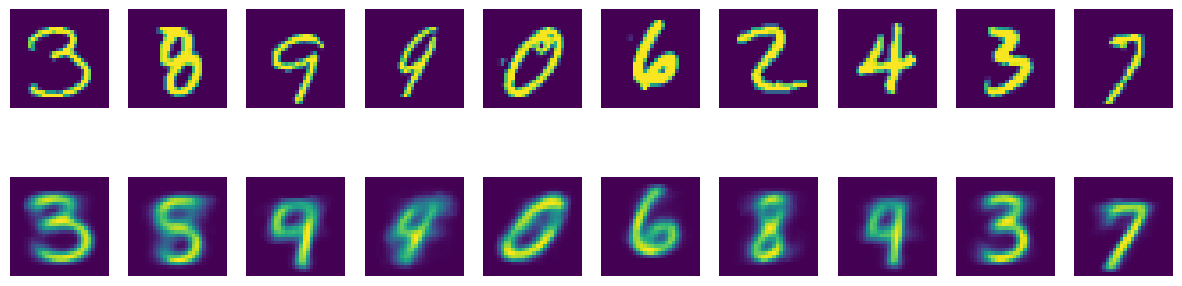

In [46]:
# Visualize reconstructions
model.eval()
test_loader = data.DataLoader(train_dataset, batch_size=10, shuffle=True)
test_images, _ = next(iter(test_loader))
test_images_flat = test_images.view(test_images.size(0), -1).to(device)

with torch.no_grad():
    reconstructed, _, _ = model(test_images_flat)

# Reshape for visualization
test_images = test_images.cpu().numpy()
reconstructed = reconstructed.view(-1, 1, 28, 28).cpu().numpy()

# Plot original and reconstructed images
fig, axes = plt.subplots(2, 10, figsize=(15, 4))
for i in range(10):
    # Original images
    axes[0, i].imshow(test_images[i][0])
    axes[0, i].axis('off')
    # Reconstructed images
    axes[1, i].imshow(reconstructed[i][0])
    axes[1, i].axis('off')
plt.show()

In [ ]:
# Random latent gen
with torch.no_grad():
    z = torch.randn(10, model.fc_mu.out_features).to(device)  # Random latent vectors
    generated = model.decoder(z).view(-1, 1, 28, 28).cpu().numpy()

# Plot generated images
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    axes[i].imshow(generated[i][0])
    axes[i].axis('off')
plt.show()

In [ ]:
# Get latent space representation
model.eval()
latents = []
labels = []

with torch.no_grad():
    for images, label in train_loader:
        images = images.view(images.size(0), -1).to(device)
        _, mu, _ = model(images)
        latents.append(mu)
        labels.append(label)

latents = torch.cat(latents).cpu().numpy()
labels = torch.cat(labels).cpu().numpy()

In [ ]:
# Latent space 2D vis

# Ensure the latent dimension is 2 for visualization
# assert model.fc_mu.out_features == 2, "Latent dimension must be 2 for 2D visualization!"

# Plot the latent space
plt.figure(figsize=(8, 6))

scatter = plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='tab10', s=10, alpha=0.7)

plt.colorbar(scatter, label="Digit Label")
plt.title("Latent Space Visualization")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.show()

In [ ]:
# Latent space 3D vis

# Ensure the latent dimension is 3 for visualization
# assert model.fc_mu.out_features == 3, "Latent dimension must be 3 for 3D visualization!"

# Plot the 3D latent space
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(latents[:, 0], latents[:, 1], latents[:, 2], c=labels, cmap='tab10', s=10, alpha=0.7)

fig.colorbar(scatter, ax=ax, label="Digit Label")
ax.set_title("3D Latent Space Visualization")
ax.set_xlabel("Latent Dimension 1")
ax.set_ylabel("Latent Dimension 2")
ax.set_zlabel("Latent Dimension 3")

plt.show()

In [ ]:
# take k samples of latents to speed up t-SNE
# k = 4000  
# indices = torch.randperm(latents.shape[0])[:k]
# sampled_latents = latents[indices]
# sampled_labels = labels[indices]
sampled_latents = latents
sampled_labels = labels

In [ ]:
# Perform t-SNE on latent vectors
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
latent_2d_tsne = tsne.fit_transform(sampled_latents)

# Plot the t-SNE results
plt.figure(figsize=(8, 8))

scatter = plt.scatter(latent_2d_tsne[:, 0], latent_2d_tsne[:, 1], c=sampled_labels, cmap='tab10', s=5)

plt.colorbar(scatter, label="Class")
plt.title("Latent Space Visualization with t-SNE")
plt.show()

In [ ]:
# Perform t-SNE on latent vectors
tsne = TSNE(n_components=3, perplexity=30, random_state=42)
latent_3d_tsne = tsne.fit_transform(sampled_latents)

# Plot the 3D latent space
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(latent_3d_tsne[:, 0], latent_3d_tsne[:, 1], latent_3d_tsne[:, 2], c=sampled_labels, cmap='tab10', s=10, alpha=0.7)

fig.colorbar(scatter, ax=ax, label="Digit Label")
ax.set_title("Latent Space Visualization with t-SNE")

plt.show()